<a href="https://colab.research.google.com/github/yura123123/Deep_Learning/blob/main/Chornii_Yurii_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [7]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
from torchvision import models
from torchsummary import summary
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
matplotlib.style.use('ggplot')
'''SEED Everything'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True # keep True if all the input have same size.
SEED=42
seed_everything(SEED=SEED)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

batch_size = 16
epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_paths = list(paths.list_images('/content/drive/MyDrive/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")

# divide the data into train, validation, and test set
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

train_data = ImageDataset(x_train, y_train, train_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Total number of classes: 101
x_train examples: (6941,)
x_test examples: (1736,)


Dataloaders

In [32]:
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [33]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.fc = nn.Linear(20280, 101)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return self.fc(x)


net = Net().to(device)

In [34]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 222, 222]             280
         MaxPool2d-2         [-1, 10, 111, 111]               0
            Conv2d-3         [-1, 20, 109, 109]           1,820
         MaxPool2d-4           [-1, 20, 54, 54]               0
            Conv2d-5           [-1, 30, 52, 52]           5,430
         MaxPool2d-6           [-1, 30, 26, 26]               0
            Linear-7                  [-1, 101]       2,048,381
Total params: 2,055,911
Trainable params: 2,055,911
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.73
Params size (MB): 7.84
Estimated Total Size (MB): 16.15
----------------------------------------------------------------


Optimizer

In [35]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)

Loss function

In [36]:
criterion = nn.CrossEntropyLoss()

Training function

In [37]:
def fit(model, dataloader, optimizer, criterion):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader),
                        total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

Validation function

In [38]:
def validate(model, dataloader, optimizer, criterion):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader),
                            total=int(len(test_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [45]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(net, trainloader,optimizer,criterion)
    val_epoch_loss, val_epoch_accuracy = validate(net, testloader,optimizer,criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')
torch.save(net.state_dict(), f"/content/outputs/cnn-epochs{epochs}.pth")

Training on 6941 examples, validating on 1736 examples...
Epoch 1 of 10
Training


434it [00:26, 16.61it/s]


Train Loss: 0.0007, Train Acc: 99.90
Validating


109it [00:08, 13.57it/s]                         


Test Loss: 0.2192, Test Acc: 57.78
Epoch 2 of 10
Training


434it [00:25, 17.18it/s]


Train Loss: 0.0008, Train Acc: 99.93
Validating


109it [00:06, 16.09it/s]                         


Test Loss: 0.1875, Test Acc: 58.12
Epoch 3 of 10
Training


434it [00:24, 17.87it/s]                         


Train Loss: 0.0004, Train Acc: 99.94
Validating


109it [00:05, 19.52it/s]                         


Test Loss: 0.2051, Test Acc: 58.41
Epoch 4 of 10
Training


434it [00:23, 18.13it/s]                         


Train Loss: 0.0009, Train Acc: 99.91
Validating


109it [00:05, 19.30it/s]                         


Test Loss: 0.1986, Test Acc: 57.83
Epoch 5 of 10
Training


434it [00:24, 17.36it/s]                         


Train Loss: 0.0006, Train Acc: 99.94
Validating


109it [00:05, 19.61it/s]


Test Loss: 0.1817, Test Acc: 57.72
Epoch 6 of 10
Training


434it [00:23, 18.23it/s]                         


Train Loss: 0.0008, Train Acc: 99.90
Validating


109it [00:05, 19.57it/s]                         


Test Loss: 0.1825, Test Acc: 57.43
Epoch 7 of 10
Training


434it [00:23, 18.33it/s]


Train Loss: 0.0004, Train Acc: 99.94
Validating


109it [00:05, 19.39it/s]                         


Test Loss: 0.1754, Test Acc: 58.01
Epoch 8 of 10
Training


434it [00:23, 18.22it/s]                         


Train Loss: 0.0016, Train Acc: 99.55
Validating


109it [00:05, 19.36it/s]                         


Test Loss: 0.2833, Test Acc: 51.61
Epoch 9 of 10
Training


434it [00:24, 18.03it/s]


Train Loss: 0.0014, Train Acc: 99.65
Validating


109it [00:05, 19.10it/s]                         


Test Loss: 0.2816, Test Acc: 53.46
Epoch 10 of 10
Training


434it [00:24, 17.88it/s]


Train Loss: 0.0008, Train Acc: 99.83
Validating


109it [00:05, 19.07it/s]                         


Test Loss: 0.2839, Test Acc: 55.59
5.0730970342954 minutes


Accuracy plots

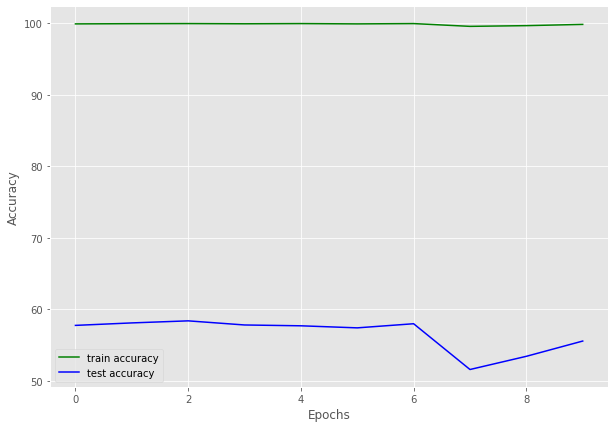

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/outputs/accuracy.png')

Loss plots

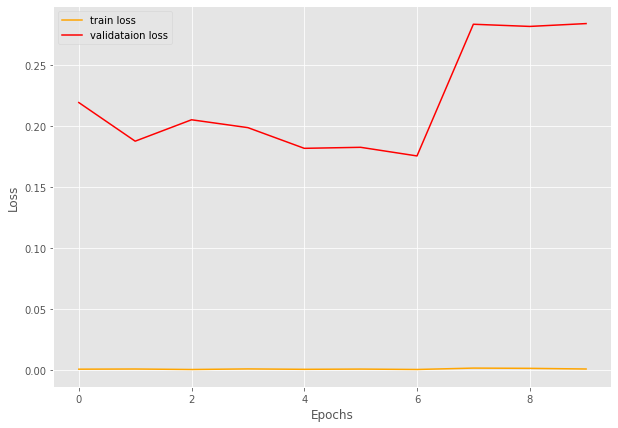

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/outputs/loss.png')

In [48]:
wide_resnet = models.wide_resnet50_2(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [49]:
summary(wide_resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Freeze filter weights

In [50]:
for param in wide_resnet.parameters():
    param.requires_grad=False

num_ftrs = wide_resnet.fc.in_features
wide_resnet.fc = nn.Linear(num_ftrs, 101)
wide_resnet = wide_resnet.to(device)

In [51]:
summary(wide_resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [52]:
for name, param in wide_resnet.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([128, 64, 1, 1]) False
layer1.0.bn1.weight torch.Size([128]) False
layer1.0.bn1.bias torch.Size([128]) False
layer1.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.0.bn2.weight torch.Size([128]) False
layer1.0.bn2.bias torch.Size([128]) False
layer1.0.conv3.weight torch.Size([256, 128, 1, 1]) False
layer1.0.bn3.weight torch.Size([256]) False
layer1.0.bn3.bias torch.Size([256]) False
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1]) False
layer1.0.downsample.1.weight torch.Size([256]) False
layer1.0.downsample.1.bias torch.Size([256]) False
layer1.1.conv1.weight torch.Size([128, 256, 1, 1]) False
layer1.1.bn1.weight torch.Size([128]) False
layer1.1.bn1.bias torch.Size([128]) False
layer1.1.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.1.bn2.weight torch.Size([128]) False
layer1.1.bn2.bias torch.Size([128]) False
layer1.1

In [55]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(wide_resnet, trainloader,optimizer,criterion)
    val_epoch_loss, val_epoch_accuracy = validate(wide_resnet, testloader,optimizer,criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')
torch.save(wide_resnet.state_dict(), f"/content/outputs/wide_resnet-epochs{epochs}.pth")

Training on 6941 examples, validating on 1736 examples...
Epoch 1 of 10
Training


434it [01:50,  3.92it/s]


Train Loss: 0.2899, Train Acc: 3.62
Validating


109it [00:29,  3.68it/s]


Test Loss: 0.2923, Test Acc: 1.90
Epoch 2 of 10
Training


434it [01:46,  4.09it/s]


Train Loss: 0.2899, Train Acc: 3.85
Validating


109it [00:25,  4.23it/s]


Test Loss: 0.2918, Test Acc: 2.94
Epoch 3 of 10
Training


434it [01:46,  4.06it/s]


Train Loss: 0.2900, Train Acc: 3.60
Validating


109it [00:25,  4.22it/s]


Test Loss: 0.2922, Test Acc: 3.11
Epoch 4 of 10
Training


434it [01:46,  4.08it/s]


Train Loss: 0.2899, Train Acc: 3.67
Validating


109it [00:25,  4.23it/s]


Test Loss: 0.2925, Test Acc: 2.36
Epoch 5 of 10
Training


434it [01:46,  4.08it/s]


Train Loss: 0.2899, Train Acc: 3.57
Validating


109it [00:25,  4.23it/s]


Test Loss: 0.2921, Test Acc: 2.65
Epoch 6 of 10
Training


434it [01:46,  4.06it/s]


Train Loss: 0.2898, Train Acc: 3.80
Validating


109it [00:25,  4.23it/s]


Test Loss: 0.2920, Test Acc: 2.42
Epoch 7 of 10
Training


434it [01:46,  4.08it/s]


Train Loss: 0.2899, Train Acc: 3.46
Validating


109it [00:25,  4.24it/s]


Test Loss: 0.2922, Test Acc: 1.73
Epoch 8 of 10
Training


434it [01:46,  4.09it/s]


Train Loss: 0.2899, Train Acc: 3.96
Validating


109it [00:25,  4.24it/s]


Test Loss: 0.2921, Test Acc: 2.59
Epoch 9 of 10
Training


434it [01:46,  4.08it/s]


Train Loss: 0.2900, Train Acc: 3.65
Validating


109it [00:25,  4.24it/s]


Test Loss: 0.2922, Test Acc: 2.53
Epoch 10 of 10
Training


434it [01:46,  4.09it/s]


Train Loss: 0.2898, Train Acc: 3.49
Validating


109it [00:25,  4.24it/s]


Test Loss: 0.2921, Test Acc: 2.36
22.171361712614694 minutes


Accuracy plots

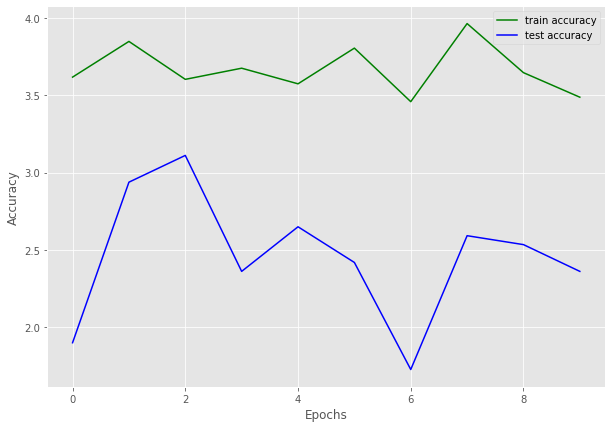

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/outputs/wide_resnet-accuracy.png')

Loss plots

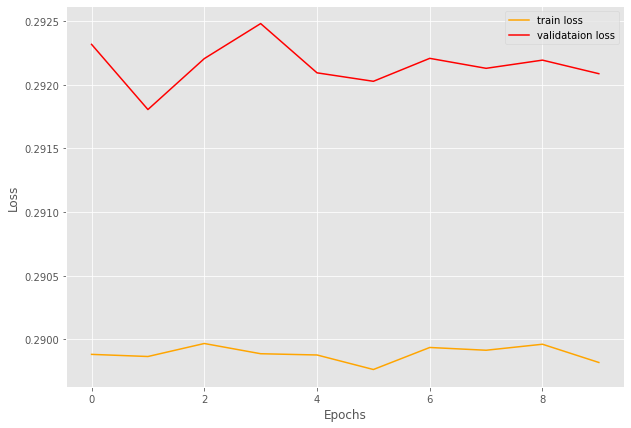

In [57]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/outputs/wide_resnet-loss.png')

In [58]:
wide_resnet_ft = models.wide_resnet50_2(pretrained=True).to(device)

# freeze filter weights for the first 8 layers (out of 10)
ct = 0
for child in wide_resnet_ft.children():
  ct += 1
  if ct < 8:
      for param in child.parameters():
          param.requires_grad = False
  else:
      for param in child.parameters():
          param.requires_grad = True

num_ftrs = wide_resnet_ft.fc.in_features
wide_resnet_ft.fc = nn.Linear(num_ftrs, 101)
wide_resnet_ft = wide_resnet_ft.to(device)

for name, param in wide_resnet_ft.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([128, 64, 1, 1]) False
layer1.0.bn1.weight torch.Size([128]) False
layer1.0.bn1.bias torch.Size([128]) False
layer1.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.0.bn2.weight torch.Size([128]) False
layer1.0.bn2.bias torch.Size([128]) False
layer1.0.conv3.weight torch.Size([256, 128, 1, 1]) False
layer1.0.bn3.weight torch.Size([256]) False
layer1.0.bn3.bias torch.Size([256]) False
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1]) False
layer1.0.downsample.1.weight torch.Size([256]) False
layer1.0.downsample.1.bias torch.Size([256]) False
layer1.1.conv1.weight torch.Size([128, 256, 1, 1]) False
layer1.1.bn1.weight torch.Size([128]) False
layer1.1.bn1.bias torch.Size([128]) False
layer1.1.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.1.bn2.weight torch.Size([128]) False
layer1.1.bn2.bias torch.Size([128]) False
layer1.1

In [ ]:
epochs = 5
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

# optimizer
optimizer2 = optim.Adam(wide_resnet_ft.parameters(), lr=1e-3)
# loss function
criterion2 = nn.CrossEntropyLoss()

print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(wide_resnet_ft,
                                                 trainloader,
                                                 optimizer2,
                                                 criterion2)
    val_epoch_loss, val_epoch_accuracy = validate(wide_resnet_ft,
                                                  testloader,
                                                  optimizer2,
                                                  criterion2)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Training on 6941 examples, validating on 1736 examples...
Epoch 1 of 5
Training


 20%|██        | 88/433 [00:30<01:49,  3.16it/s]

In [ ]:
end = time.time()
print((end-start)/60, 'minutes')
torch.save(wide_resnet_ft.state_dict(), f"/content/outputs/wide_resnet_ft-epochs{epochs}.pth")
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/outputs/wide_resnet_ft-accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/outputs/wide_resnet_ft-loss.png')

In [ ]:
import cv2
from PIL import Image

net.load_state_dict(torch.load('/content/outputs/cnn-epochs20.pth'))
net.eval()

# load one batch of testing images
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx])
# print(img.shape)

img = np.moveaxis(img, 0, -1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# use OpenCV's filter2D function
# apply a specific set of filter weights (like the one's displayed above) to the test image
# print(img.shape)
plt.imshow(np.asarray(img))

# first conv layer - for 10 filters
weights = net.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()